In [ ]:
import time, random, os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [ ]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device, "| seed:", SEED)

Device: cpu | seed: 0


##Part A — Warm‑up: tensors, shapes, autograd (PyTorch basics)

In [ ]:
## Part A1: shapes demo
a = torch.randn(3)
b = torch.randn(3,4)
c = torch.randn(4,3)

print("\nA1 shapes:")
print("b @ c:", b.shape, "@", c.shape, "=", (b @ c).shape)
print("b * b:", b.shape, "*", b.shape, "=", (b*b).shape)
print("broadcast b * a.view(3,1):", b.shape, "*", a.view(3,1).shape, "=", (b * a.view(3,1)).shape)
print("reshape b -> (12,):", b.shape, "->", b.reshape(12).shape)
print("permute b (1,0):", b.shape, "->", b.permute(1,0).shape)
print("flatten b:", b.shape, "->", b.flatten().shape)



A1 shapes:
b @ c: torch.Size([3, 4]) @ torch.Size([4, 3]) = torch.Size([3, 3])
b * b: torch.Size([3, 4]) * torch.Size([3, 4]) = torch.Size([3, 4])
broadcast b * a.view(3,1): torch.Size([3, 4]) * torch.Size([3, 1]) = torch.Size([3, 4])
reshape b -> (12,): torch.Size([3, 4]) -> torch.Size([12])
permute b (1,0): torch.Size([3, 4]) -> torch.Size([4, 3])
flatten b: torch.Size([3, 4]) -> torch.Size([12])


In [ ]:
## Part A2: autograd check
x = torch.tensor(2.0)
w = torch.tensor(3.0, requires_grad=True)
bb = torch.tensor(-1.0, requires_grad=True)

y = (w*x + bb)**2
y.backward()

z = (w.detach()*x + bb.detach())
dw_hand = 2*z*x
db_hand = 2*z

print("\nA2 gradients:")
print("dw autograd:", w.grad.item(), "| dw hand:", dw_hand.item())
print("db autograd:", bb.grad.item(), "| db hand:", db_hand.item())



A2 gradients:
dw autograd: 20.0 | dw hand: 20.0
db autograd: 10.0 | db hand: 10.0


##Part B — Load + explore CIFAR‑10 (data pipeline)

In [ ]:

# B3 Preprocessing
MEAN = (0.4914, 0.4822, 0.4465)
STD  = (0.2470, 0.2435, 0.2616)

transform = T.Compose([
    T.ToTensor(),
    T.Normalize(MEAN, STD)
])


In [ ]:
# B1 Load dataset
train_full = torchvision.datasets.CIFAR10("./data", train=True, download=True, transform=transform)
test_set   = torchvision.datasets.CIFAR10("./data", train=False, download=True, transform=transform)

val_ratio = 0.1
n_val = int(len(train_full) * val_ratio)
n_train = len(train_full) - n_val

train_set, val_set = random_split(train_full, [n_train, n_val],
                                  generator=torch.Generator().manual_seed(SEED))

BATCH_SIZE = 128
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print("Train size:", len(train_set))
print("Val size:", len(val_set))
print("Test size:", len(test_set))

xb, yb = next(iter(train_loader))
print("One batch shape:", xb.shape, yb.shape)


Train size: 45000
Val size: 5000
Test size: 10000
One batch shape: torch.Size([128, 3, 32, 32]) torch.Size([128])


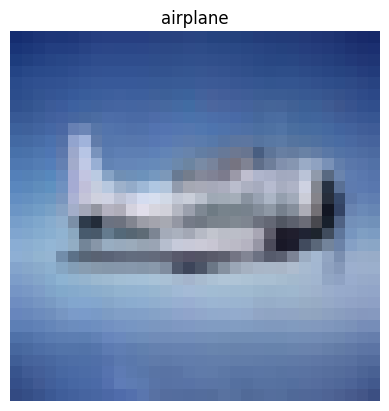

Normalization helps optimization by keeping inputs at similar scale.


In [ ]:
# B2 Visualization
classes = train_full.classes

def denorm(img):
    mean = torch.tensor(MEAN).view(3,1,1)
    std  = torch.tensor(STD).view(3,1,1)
    return (img*std + mean).clamp(0,1)

plt.figure()
plt.imshow(denorm(xb[0]).permute(1,2,0))
plt.title(classes[yb[0]])
plt.axis("off")
plt.show()

print("Normalization helps optimization by keeping inputs at similar scale.")

##Part C — Build a baseline model (MLP) + a correct training loop

In [ ]:
# C1 Model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3*32*32, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)  # logits
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

model = MLP().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# C3 Parameters vs Hyperparameters
print("\nParameters:")
total = 0
for name, p in model.named_parameters():
    print(name, p.shape)
    total += p.numel()
print("Total parameters:", total)

print("\nHyperparameters:")
print("Optimizer: Adam")
print("Learning rate: 1e-3")
print("Batch size:", BATCH_SIZE)
print("Epochs: 10")


Parameters:
net.0.weight torch.Size([256, 3072])
net.0.bias torch.Size([256])
net.2.weight torch.Size([128, 256])
net.2.bias torch.Size([128])
net.4.weight torch.Size([10, 128])
net.4.bias torch.Size([10])
Total parameters: 820874

Hyperparameters:
Optimizer: Adam
Learning rate: 1e-3
Batch size: 128
Epochs: 10


Epoch 1: train_acc=0.4133, val_acc=0.4492
Epoch 2: train_acc=0.4883, val_acc=0.4742
Epoch 3: train_acc=0.5292, val_acc=0.4962
Epoch 4: train_acc=0.5598, val_acc=0.5042
Epoch 5: train_acc=0.5856, val_acc=0.5054
Epoch 6: train_acc=0.6099, val_acc=0.5122
Epoch 7: train_acc=0.6286, val_acc=0.5016
Epoch 8: train_acc=0.6492, val_acc=0.5202
Epoch 9: train_acc=0.6669, val_acc=0.5110
Epoch 10: train_acc=0.6898, val_acc=0.5136


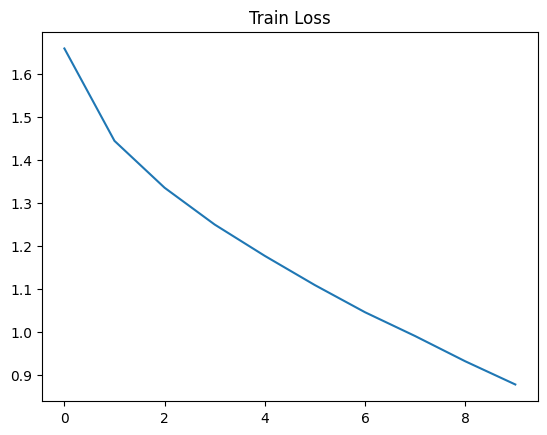

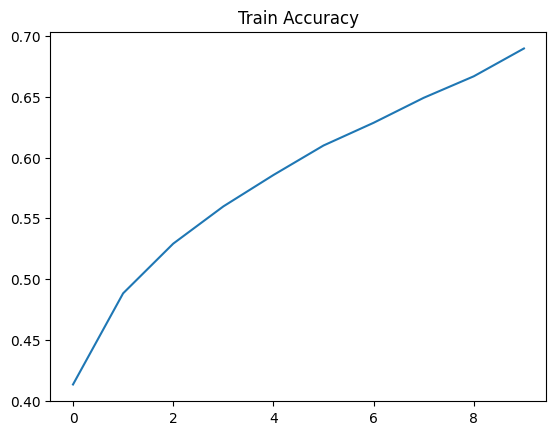

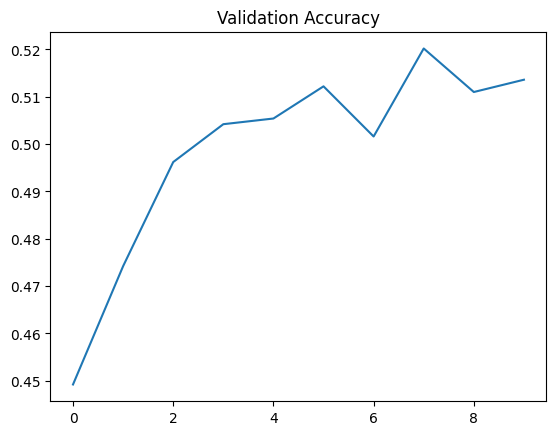

Best validation accuracy: 0.5202
Best epoch: 8


In [ ]:
# C2 Training loop
EPOCHS = 10
train_acc_list = []
val_acc_list = []
train_loss_list = []

best_val = 0
best_epoch = 0

for epoch in range(EPOCHS):
  # Train
    model.train()
    correct = 0
    total_samples = 0
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        outputs = model(xb)
        loss = loss_fn(outputs, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == yb).sum().item()
        total_samples += yb.size(0)
        train_acc = correct / total_samples
    train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            preds = outputs.argmax(1)
            correct += (preds == yb).sum().item()
            total_samples += yb.size(0)

    val_acc = correct / total_samples
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    train_loss_list.append(train_loss)

    if val_acc > best_val:
        best_val = val_acc
        best_epoch = epoch + 1
        torch.save(model.state_dict(), "best_model.pt")

    print(f"Epoch {epoch+1}: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")
# Plots
plt.plot(train_loss_list)
plt.title("Train Loss")
plt.show()

plt.plot(train_acc_list)
plt.title("Train Accuracy")
plt.show()

plt.plot(val_acc_list)
plt.title("Validation Accuracy")
plt.show()

print("Best validation accuracy:", best_val)
print("Best epoch:", best_epoch)


##Part D — Experiments (hyperparameters + model capacity)

In [ ]:

def run_experiment(lr=1e-3, batch_size=128, optimizer_name="adam", hidden=256):

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(3*32*32, hidden),
        nn.ReLU(),
        nn.Linear(hidden, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    ).to(device)

    if optimizer_name == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    loss_fn = nn.CrossEntropyLoss()

    best_val = 0

    for epoch in range(5):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = loss_fn(model(xb), yb)
            loss.backward()
            optimizer.step()

        # validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb).argmax(1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)

        val_acc = correct / total
        best_val = max(best_val, val_acc)

    return best_val


results = []

results.append(("baseline", run_experiment()))
results.append(("lr_3e-4", run_experiment(lr=3e-4)))
results.append(("lr_3e-3", run_experiment(lr=3e-3)))
results.append(("batch_256", run_experiment(batch_size=256)))
results.append(("sgd", run_experiment(optimizer_name="sgd", lr=0.05)))
results.append(("wider_512", run_experiment(hidden=512)))

print("\n=== Results ===")
for name, acc in results:
    print(name, "best val acc:", round(acc,4))


=== Results ===
baseline best val acc: 0.5146
lr_3e-4 best val acc: 0.5098
lr_3e-3 best val acc: 0.475
batch_256 best val acc: 0.511
sgd best val acc: 0.4458
wider_512 best val acc: 0.516
